In [74]:
using Flux, Random, Statistics, XLSX, PyCall, PyPlot, LaTeXStrings
@pyimport numpy as np
@pyimport scienceplots
plt.style.use(["science","ieee"])
# Flux.jl v0.16.3

### 1. Flux.jlを使ったニューラルネットワークの定義〜パラメータ更新まで

In [75]:
# パラメータ定義
input_size = 1   # 入力数
hidden_size = 3  # 隠れ層ユニット数
output_size = 1  # 出力数


1

In [76]:
# ランダムシード
rng = MersenneTwister(12345)

# FNNモデル定義
#model = Chain(
#              Dense(input_size => hidden_size, tanh; init = Flux.glorot_uniform(MersenneTwister(1234))),
#              Dense(hidden_size => output_size, identity; init=Flux.glorot_uniform(MersenneTwister(1234)))
#              )

# RNNモデル定義
model = Chain(
              RNN(input_size => hidden_size, tanh; init_kernel=Flux.glorot_uniform(rng), init_recurrent_kernel=Flux.glorot_uniform(rng)),
              Dense(hidden_size, output_size, identity; init=Flux.glorot_uniform(rng))
              )

# LSTMモデル定義
#model = Chain(
#              LSTM(input_size => hidden_size, tanh; init_kernel=Flux.glorot_uniform(rng), init_recurrent_kernel=Flux.glorot_uniform(rng)),
#              Dense(hidden_size, output_size; init=Flux.glorot_uniform(rng))
#              )

Chain(
  RNN(1 => 3, tanh),                    # 15 parameters
  Dense(3 => 1),                        # 4 parameters
)                   # Total: 5 arrays, 19 parameters, 420 bytes.

In [77]:
# サンプルデータ
batch_size = 5  # バッチサイズ
seq_length = 3  # シーケンス長
Random.seed!(1)

# FNN用
#x = rand(Float32, input_size, batch_size)   # 入力
#y = rand(Float32, output_size, batch_size)  # 出力の正解

# RNN用
x = rand(Float32, input_size, seq_length, batch_size)   # 入力
y = rand(Float32, output_size, seq_length, batch_size)  # 出力の正解

x,y

(Float32[0.07235652 0.073366344 0.05444044;;; 0.34924144 0.02699393 0.6988267;;; 0.0009768009 0.6282647 0.89372504;;; 0.914929 0.67940146 0.19280809;;; 0.19083989 0.77018034 0.382926], Float32[0.7771069 0.67026395 0.4359008;;; 0.16771209 0.08160931 0.5710874;;; 0.7299426 0.45280856 0.63502586;;; 0.30232543 0.5271945 0.001350224;;; 0.62544286 0.56702363 0.6109088])

In [78]:
# 順伝播計算 (初期隠れ状態はデフォルトでゼロになる)
model(x)

1×3×5 Array{Float32, 3}:
[:, :, 1] =
 0.0769055  0.0542537  -0.137018

[:, :, 2] =
 0.36366  -0.0741125  -0.0329501

[:, :, 3] =
 0.00103919  0.625598  0.638642

[:, :, 4] =
 0.856093  0.461146  -0.470394

[:, :, 5] =
 0.201708  0.671016  -0.00353729

In [79]:
# 損失関数定義
loss(m, x, y) = Flux.mse(m(x), y)

loss (generic function with 1 method)

In [80]:
# 最適化方法定義
opt_state = Flux.setup(Adam(0.001), model)

(layers = ((cell = (σ = (), Wi = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0; 0.0; 0.0;;], Float32[0.0; 0.0; 0.0;;], (0.9, 0.999))), Wh = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0], (0.9, 0.999)))),), (weight = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 0.0], Float32[0.0 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0], Float32[0.0], (0.9, 0.999))), σ = ())),)

In [81]:
# 勾配計算
g = gradient(m -> loss(m, x, y), model)[1]

(layers = ((cell = (σ = nothing, Wi = Float32[-0.16262601; -0.15575394; 0.14025605;;], Wh = Float32[-0.05934055 0.28621054 0.1656726; -0.020937223 0.039205417 0.03276062; 0.039834976 -0.14826816 -0.09341866], bias = Float32[-0.92238045, -0.67274106, 0.623083]),), (weight = Float32[0.10543861 0.16257961 -0.03465954], bias = Float32[-0.5231537], σ = nothing)),)

In [82]:
# 各パラメータの勾配抽出  RNN_layer(Wi, Wh, bias), Dense_layer(weight, bias)
g.layers[1].cell.bias

3-element Vector{Float32}:
 -0.92238045
 -0.67274106
  0.623083

In [83]:
# モデルパラメータ更新
Flux.update!(opt_state, model, g)

((layers = ((cell = (σ = (), Wi = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[-0.0162626; -0.0155754; 0.0140256;;], Float32[2.64469f-5; 2.4259f-5; 1.96715f-5;;], (0.81, 0.998001))), Wh = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[-0.00593406 0.0286211 0.0165673; -0.00209372 0.00392054 0.00327606; 0.0039835 -0.0148268 -0.00934187], Float32[3.52126f-6 8.19154f-5 2.74471f-5; 4.38362f-7 1.53704f-6 1.07324f-6; 1.5868f-6 2.19832f-5 8.72693f-6], (0.81, 0.998001))), bias = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[-0.0922381, -0.0672741, 0.0623083], Float32[0.000850775, 0.000452575, 0.000388227], (0.81, 0.998001)))),), (weight = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0105439 0.016258 -0.00346595], Float32[1.11172f-5 2.64318f-5 1.20127f-6], (0.81, 0.998001))), bias = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[-0.0523154], Float32[0.000273686], (0.81, 0.998001))), σ = ())),), 

### 2. FNN&RNNを用いた船舶操縦運動モデルの同定

In [84]:
# MMGモデルパラメータ構造体
mutable struct MMGparams
  L_pp::Float32
  B::Float32
  d::Float32
  nabla::Float32
  x_G::Float32
  C_b::Float32
  D_p::Float32
  H_R::Float32
  A_R::Float32
  t_P::Float32
  w_P0::Float32
  m_x_dash::Float32
  m_y_dash::Float32
  J_z_dash::Float32
  t_R::Float32
  x_R_dash::Float32
  a_H::Float32
  x_H_dash::Float32
  γ_R_minus::Float32
  γ_R_plus::Float32
  l_r_dash::Float32
  x_P_dash::Float32
  ϵ::Float32
  κ::Float32
  f_α::Float32
  ρ::Float32
  m::Float32
  I_zG::Float32
  η::Float32
  m_x::Float32
  m_y::Float32
  J_z::Float32
  x_R::Float32
  x_H::Float32
  l_R::Float32
  x_P::Float32
  k_0::Float32
  k_1::Float32
  k_2::Float32
  R_0_dash::Float32
  X_vv_dash::Float32
  X_vr_dash::Float32
  X_rr_dash::Float32
  X_vvvv_dash::Float32
  Y_v_dash::Float32
  Y_r_dash::Float32
  Y_vvv_dash::Float32
  Y_vvr_dash::Float32
  Y_vrr_dash::Float32
  Y_rrr_dash::Float32
  N_v_dash::Float32
  N_r_dash::Float32
  N_vvv_dash::Float32
  N_vvr_dash::Float32
  N_vrr_dash::Float32
  N_rrr_dash::Float32
end

# MMGモデルパラメータ定義
function mmg_params()
  # Default parameters
  L_pp = 7.00                                # 船長Lpp[m]
  B = 1.27                                   # 船幅[m]
  d = 0.46                                   # 喫水[m]
  nabla = 3.27                               # 排水量[m^3]
  x_G = 0.25                                 # 重心位置[m]
  C_b = 0.810                                # 方形係数[-]
  D_p = 0.216                                # プロペラ直径[m]
  H_R = 0.345                                # 舵高さ[m]
  A_R = 0.0539                               # 舵断面積[m^2]
  t_P = 0.220                                # 推力減少率
  w_P0 = 0.40                                # 有効伴流率
  m_x_dash = 0.022                           # 付加質量x(無次元)
  m_y_dash = 0.223                           # 付加質量y(無次元)
  J_z_dash = 0.011                           # 付加質量Izz(無次元)
  t_R = 0.387                                # 操縦抵抗減少率
  x_R_dash = -0.500                          # 舵の相対位置
  a_H = 0.312                                # 舵力増加係数
  x_H_dash = -0.464                          # 舵力増分作用位置
  γ_R_minus = 0.395                          # 整流係数(左舷方向)
  γ_R_plus = 0.640                           # 整流係数(右舷方向)
  l_r_dash = -0.710                          # 船長に対する舵位置
  x_P_dash = -0.690                          # 船長に対するプロペラ位置
  ϵ = 1.09                                   # プロペラ・舵位置伴流係数比
  κ = 0.50                                   # 修正係数
  f_α = 2.747                                # 直圧力勾配係数
  ρ = 1000.0                                 # 密度[kg/m^3]
  k_0 = 0.2931
  k_1 = -0.2753
  k_2 = -0.1385

  m = ρ * nabla                              # 質量(無次元化)[kg]
  I_zG = ρ * nabla * ((0.25 * L_pp)^2)       # 慣性モーメント[-]
  A_R = A_R                                  # 船の断面に対する舵面積比[-]
  η = D_p / H_R                              # プロペラ直径に対する舵高さ(Dp/H)
  m_x = (0.5 * ρ * (L_pp^2) * d) * m_x_dash  # 付加質量x(無次元)
  m_y = (0.5 * ρ * (L_pp^2) * d) * m_y_dash  # 付加質量y(無次元)
  J_z = (0.5 * ρ * (L_pp^4) * d) * J_z_dash  # 付加質量Izz(無次元)
  x_R = x_R_dash * L_pp                      # 舵の位置
  x_H = x_H_dash * L_pp                      # 舵力増分作用位置
  l_R = l_r_dash                             # 船長に対する舵位置
  x_P = x_P_dash                             # 船長に対するプロペラ位置

  # 操縦流体力微係数
  R_0_dash = 0.022
  X_vv_dash = -0.040
  X_vr_dash = 0.002
  X_rr_dash = 0.011
  X_vvvv_dash = 0.771
  Y_v_dash = -0.315
  Y_r_dash = 0.083
  Y_vvv_dash = -1.607
  Y_vvr_dash = 0.379
  Y_vrr_dash = -0.391
  Y_rrr_dash = 0.008
  N_v_dash = -0.137
  N_r_dash = -0.049
  N_vvv_dash = -0.030
  N_vvr_dash = -0.294
  N_vrr_dash = 0.055
  N_rrr_dash = -0.013

  return MMGparams(
    L_pp, B, d, nabla, x_G, C_b, D_p, H_R, A_R, t_P, w_P0, m_x_dash, m_y_dash, J_z_dash, t_R, x_R_dash, a_H, x_H_dash, γ_R_minus, γ_R_plus, l_r_dash, x_P_dash, ϵ, κ, f_α, ρ, m, I_zG, η, m_x, m_y, J_z, x_R, x_H, l_R, x_P, k_0, k_1, k_2, R_0_dash, X_vv_dash, X_vr_dash, X_rr_dash, X_vvvv_dash, Y_v_dash, Y_r_dash, Y_vvv_dash, Y_vvr_dash, Y_vrr_dash, Y_rrr_dash, N_v_dash, N_r_dash, N_vvv_dash, N_vvr_dash, N_vrr_dash, N_rrr_dash
    )
end

# MMGモデル(ミッドシップ基準)
function mmg(input, params::MMGparams)
  # input   : 入力, [u,v,r,δ,n]^T x (時間方向の)長さ
  # params  : MMGモデルのパラメータ

  ninput = size(input, 2)
  u, v, r, δ, n = input[1, :], input[2, :], input[3, :], input[4, :], input[5, :]

  U = sqrt.(u.^2 .+ v.^2)
  β = map((u_, v_) -> u_ == 0.0 ? 0.0 : atan(-v_ / u_), u, v)
  v_dash = map((U_, v_) -> U_ == 0.0 ? 0.0 : v_ / U_, U, v)
  r_dash = map((U_, r_) -> U_ == 0.0 ? 0.0 : r_ * params.L_pp / U_, U, r)

  w_P = params.w_P0 .* exp.(-4.0 .* (β .- params.x_P .* r_dash).^2)
  J = map((w_P_, u_, n_) -> n_ == 0.0 ? 0.0 : (1 - w_P_) * u_ / (n_ * params.D_p), w_P, u, n)
  K_T = params.k_0 .+ params.k_1 .* J .+ params.k_2 .* J.^2

  β_R = β .- params.l_R .* r_dash
  γ_R = map(β_R_ -> β_R_ < 0.0 ? params.γ_R_minus : params.γ_R_plus, β_R)
  v_R = U .* γ_R .* β_R
  u_R = map((w_P_, J_, K_T_, u_, n_) -> J_ == 0.0 ? sqrt(params.η * (params.κ * params.ϵ * 8.0 * params.k_0 * n_^2 * params.D_p^4 / π)^2) : u_ * (1.0 - w_P_) .* params.ϵ .* sqrt(params.η * (1.0 + params.κ * (sqrt(1.0 + 8.0 * K_T_ / (π * J_^2)) - 1.0))^2 + 1.0 - params.η), w_P, J, K_T, u, n)

  U_R = sqrt.(u_R.^2 .+ v_R.^2)
  α_R = δ .- atan.(v_R, u_R)
  F_N = (0.5 * params.A_R * params.ρ * params.f_α) .* (U_R.^2) .* sin.(α_R)

  X_H = (0.5 * params.ρ * params.L_pp * params.d) .* U.^2 .* (- params.R_0_dash .+ params.X_vv_dash .* v_dash.^2 .+ params.X_vr_dash .* v_dash .* r_dash .+ params.X_rr_dash .* r_dash.^2 .+ params.X_vvvv_dash .* v_dash.^4)
  X_R = - (1.0 - params.t_R) .* F_N .* sin.(δ)
  X_P = (1.0 - params.t_P) .* K_T .* (params.ρ .* n.^2 .* params.D_p^4)
  Y_H = (0.5 * params.ρ * params.L_pp * params.d) .* U.^2 .* (params.Y_v_dash .* v_dash .+ params.Y_r_dash .* r_dash .+ params.Y_vvv_dash .* v_dash.^3 .+ params.Y_vvr_dash .* v_dash.^2 .* r_dash .+ params.Y_vrr_dash .* v_dash .* r_dash.^2 .+ params.Y_rrr_dash .* r_dash.^3)
  Y_R = -(1 + params.a_H) .* F_N .* cos.(δ)

  N_H = (0.5 * params.ρ * params.L_pp^2 * params.d) .* U.^2 .* (params.N_v_dash .* v_dash .+ params.N_r_dash .* r_dash .+ params.N_vvv_dash .* v_dash.^3 .+ params.N_vvr_dash .* v_dash.^2 .* r_dash .+ params.N_vrr_dash .* v_dash .* r_dash.^2 .+ params.N_rrr_dash .* r_dash.^3)
  N_R = -(params.x_R + params.a_H * params.x_H) .* F_N .* cos.(δ)
  
  du = ((X_H .+ X_R .+ X_P) .+ (params.m + params.m_y) .* v .* r .+ params.x_G .* params.m .* r.^2) ./ (params.m + params.m_x)
  dv = ((params.x_G^2 * params.m^2) .* u .* r .- (N_H .+ N_R) .* (params.x_G * params.m) .+ (Y_H .+ Y_R .- (params.m + params.m_x) .* u .* r) .* (params.I_zG + params.J_z + params.x_G^2 * params.m)) ./ ((params.I_zG + params.J_z + params.x_G^2 * params.m) * (params.m + params.m_y) - (params.x_G^2 * params.m^2))
  dr = (N_H .+ N_R .- params.x_G .* params.m .* (dv .+ u .* r)) ./ (params.I_zG + params.J_z + params.x_G^2 * params.m)

  return cat(reshape(du, 1, ninput), cat(reshape(dv, 1, ninput), reshape(dr, 1, ninput), dims=1), dims=1)
end

# 固定座標系の位置を計算するための回転行列
function Rotate_mat(Ψ, u)
  dx0 = zeros(Float32, 3, 1)
  dx0[1, 1] = u[1] * cos(Ψ) - u[2] * sin(Ψ)
  dx0[2, 1] = u[1] * sin(Ψ) + u[2] * cos(Ψ)
  dx0[3, 1] = u[3]
  return dx0
end

# 時系列データからFNN訓練に用いる入出力データを生成する関数
function prepare_fnn_dataset(data)
  input = data[5:9,:]
  output = data[2:4,:]
  input_max = maximum(abs.(input), dims=2)
  output_max = maximum(abs.(output), dims=2)
  batch_size = size(input, 2)
  return input, output, input_max, output_max, batch_size
end

# 時系列データからRNNの訓練に用いる入出力データを生成する関数
function prepare_rnn_dataset(data, memory_step)
  input, output = [], []
  for i in 1:(size(data, 2) - memory_step + 1)
      push!(input, data[5:9, i:i+memory_step-1])
      push!(output, data[2:4, i+memory_step-1])
  end
  input_max = maximum(abs.(hcat(input...)), dims=2)
  output_max = maximum(abs.(hcat(output...)), dims=2)
  input_rnn = reshape(hcat(input...), 5, memory_step, :)
  output_rnn = reshape(hcat(output...), 3, 1, :)
  batch_size = size(input_rnn, 3)
  return input_rnn, output_rnn, input_max, output_max, batch_size
end

# 隠れ層1層目がRNNのネットワーク(隠れ層の出力確認用)
function rnn_H1(input, input_h2, W2, Wh2, b2, W3, b3, hidden_state=true)
  l2 = tanh.(W2 * input + Wh2 * input_h2 .+ b2)
  l3 = W3 * l2 .+ b3
  return hidden_state ? (l3, l2) : l3
end
function rnn_H2(input, input_h2, W2, Wh2, b2, W3, b3, W4, b4, hidden_state=true)
  l2 = tanh.(W2 * input + Wh2 * input_h2 .+ b2)
  l3 = tanh.(W3 * l2 .+ b3)
  l4 = W4 * l3 .+ b4
  return hidden_state ? (l4, l3, l2) : l4
end
function rnn_H3(input, input_h2, W2, Wh2, b2, W3, b3, W4, b4, W5, b5, hidden_state=true)
  l2 = tanh.(W2 * input + Wh2 * input_h2 .+ b2)
  l3 = tanh.(W3 * l2 .+ b3)
  l4 = tanh.(W4 * l3 .+ b4)
  l5 = W5 * l4 .+ b5
  return hidden_state ? (l5, l4, l3, l2) : l5
end

# RNNモデル訓練後のシミュレーション時のタイムステップ幅に合わせて、時系列データを線形補間
function linear_interporation(m1, t_max, t_smp, dt)
  #m1     : 対象とする時系列データ
  #t_max  : シミュレーション継続時間
  #t_smp  : m1のサンプリング周期
  #dt     : シミュレーションのタイムステップ幅

  length = convert(Int32, t_max / dt) + 1
  ratio = convert(Int32, t_smp / dt)
  m2 = zeros(Float32, size(m1, 1), length)
  i = 0
  for j in 1:length-1
    remain = (j-1)%ratio
    if remain == 0
      i += 1
    end
    m2[:,j] = m1[:,i] + (m1[:,i+1] - m1[:,i]) * remain * dt / t_smp
  end
  m2[:,length] = m1[:,end]

  return m2
end

# RNNモデル訓練後のシミュレーション時に各タイムステップでの入力を生成
function input_rnn(result_mat, iteration, memory_step, ratio)
  #result_mat   : シミュレーション結果を保存している行列
  #iteration    : 繰り返し回数
  #memory_step  : メモリステップ
  #ratio        : 比べる時系列データのサンプリング周期 / シミュレーションのタイムステップ幅

  input = zeros(Float32, 5, memory_step)
  index = iteration - ratio * (memory_step-1)
  for i in 1:memory_step
    input[:,i] = result_mat[5:9,index+ratio*(i-1)]
  end
  return input
end

# MMGモデルで任意の操作量でのシミュレーション
function mmg_simulate(t_max, t_smp, δ_vector, n_vector, initial_state)
  # t_max          : シミュレーション継続時間[s]
  # t_smp          : サンプリング周期[s](入力する操作量のサンプリング周期と等しくする)
  # δ_vector       : 舵角データ
  # n_vector       : プロペラ回転数データ
  # initial_state  : 状態量の初期値([u v r x y Ψ])

  params = mmg_params()                    # MMGモデルのパラメータ
  δ_vel = 15.8f0 * π / 180f0               # 舵角の変化率[rad/s]
  dt = 0.01                                # シミュレーションのタイムステップ幅 
  iteration = convert(Int32, t_max / dt)   # 繰り返し回数

  δ = linear_interporation(reshape(δ_vector, 1, size(δ_vector, 1)), t_max, t_smp, dt)
  n = linear_interporation(reshape(n_vector, 1, size(n_vector, 1)), t_max, t_smp, dt)
  
  res = zeros(Float32, 12, iteration + 1)  # シミュレーション結果
  res[5, 1] = Float32(initial_state[1])    # u0
  res[6, 1] = Float32(initial_state[2])    # u0
  res[7, 1] = Float32(initial_state[3])    # u0
  res[8, :] = Float32.(δ)                  # δ[:]
  res[9, :] = Float32.(n)                  # n[:]
  res[10, 1] = Float32(initial_state[4])   # x0
  res[11, 1] = Float32(initial_state[5])   # y0
  res[12, 1] = Float32(initial_state[6])   # Ψ0

  t = 0.0f0
  vel = res[5:7, 1]
  pos = res[10:12, 1]

  for i in 1:iteration  # RK4法
    t += dt
    input = reshape(res[5:9, i], 5, 1)
    k1_p = Rotate_mat(pos[3,1], vel)
    k2_p = Rotate_mat(pos[3,1] + dt * k1_p[3,1] / 2.0, vel)
    k3_p = Rotate_mat(pos[3,1] + dt * k2_p[3,1] / 2.0, vel)
    k4_p = Rotate_mat(pos[3,1] + dt * k3_p[3,1], vel)
    pos .+= (k1_p .+ 2.0 .* k2_p .+ 2.0 .* k3_p .+ k4_p) .* dt ./ 6.0
    k1_v = mmg(input, params)
    k2_v = mmg(input .+ cat(dt .* k1_v ./ 2.0, zeros(2,1), dims=1), params)
    k3_v = mmg(input .+ cat(dt .* k2_v ./ 2.0, zeros(2,1), dims=1), params)
    k4_v = mmg(input .+ cat(dt .* k3_v, zeros(2,1), dims=1), params)
    vel .+= (k1_v .+ 2.0 .* k2_v .+ 2.0 .* k3_v .+ k4_v) .* dt ./ 6.0

    res[1, i+1] = t
    res[2:4, i] = k1_v
    res[5:7, i+1] = vel
    res[10:12, i+1] = pos
  end

  input = reshape(res[5:9, iteration+1], 5, 1)
  res[2:4, iteration+1] = mmg(input, params)

  t_inv = convert(Int32, t_smp / dt)
  res_de = zeros(Float32, 12, 1)
  for i in 1:t_inv:iteration+1
    res_de = cat(res_de, reshape(res[:, i], 12, 1), dims=2)
  end
  
  return res, res_de[:,2:end]
end

# MMGモデルでZ試験
function mmg_zigzag(n_con, δ_max, Ψ_switch, t_max, t_smp, initial_state, starboard::Bool)
  # n_con         : プロペラ回転数[rps] (一定)
  # δ_max         : 最大舵角の絶対値[deg]
  # Ψ_Switch      : 舵角切替時の方位角[deg]
  # t_max         : シミュレーション継続時間[s]
  # t_smp         : サンプリング周期[s]
  # initia_state  : 状態量の初期値([u v r x y Ψ])
  # starboard     : starboard=trueのとき初期旋回方向は右舷、starboard=falseのとき初期旋回方向は左舷

  params = mmg_params()                    # MMGモデルのパラメータ
  δ_vel = 15.8f0 * π / 180f0               # 舵角変化率[rad/s]
  δ_max *= π / 180f0                       # 最大舵角の絶対値[rad]
  Ψ_switch *= π / 180f0                    # 舵角切替時の方位角[rad]
  dt = 0.01                                # シミュレーションのタイムステップ幅       
  iteration = convert(Int32, t_max / dt)   # 繰り返し回数
  res = zeros(Float32, 12, iteration + 1)  # シミュレーション結果
  res[5, 1] = Float32.(initial_state[1])   # u0
  res[6, 1] = Float32.(initial_state[2])   # v0
  res[7, 1] = Float32.(initial_state[3])   # r0
  res[8, 1] = 0.0f0                        # δ0
  res[9, :] .= n_con                       # n0
  res[10, 1] = Float32.(initial_state[4])  # x0
  res[11, 1] = Float32.(initial_state[5])  # y0
  res[12, 1] = Float32.(initial_state[6])  # Ψ0

  t = 0.0f0
  vel = res[5:7, 1]
  δ = res[8, 1]
  pos = res[10:12, 1]

  for i in 1:iteration  # RK4法
    t += dt
    input = reshape(res[5:9, i], 5, 1)
    k1_p = Rotate_mat(pos[3,1], vel)
    k2_p = Rotate_mat(pos[3,1] + dt * k1_p[3,1] / 2.0, vel)
    k3_p = Rotate_mat(pos[3,1] + dt * k2_p[3,1] / 2.0, vel)
    k4_p = Rotate_mat(pos[3,1] + dt * k3_p[3,1], vel)
    pos .+= (k1_p .+ 2.0 .* k2_p .+ 2.0 .* k3_p .+ k4_p) .* dt ./ 6.0
    k1_v = mmg(input, params)
    k2_v = mmg(input .+ cat(dt .* k1_v ./ 2.0, zeros(2,1), dims=1), params)
    k3_v = mmg(input .+ cat(dt .* k2_v ./ 2.0, zeros(2,1), dims=1), params)
    k4_v = mmg(input .+ cat(dt .* k3_v, zeros(2,1), dims=1), params)
    vel .+= (k1_v .+ 2.0 .* k2_v .+ 2.0 .* k3_v .+ k4_v) .* dt ./ 6.0

    if starboard == 1 
      if (δ + δ_vel * dt) > δ_max
        δ = δ_max
      else
        δ += δ_vel * dt
      end
      if pos[3,1] >= Ψ_switch
          starboard = 0
      end
    elseif starboard == 0
      if (δ - δ_vel * dt) < -δ_max
        δ = -δ_max
      else
      δ -= δ_vel * dt
      end
      if pos[3,1] <= -Ψ_switch
        starboard = 1
      end
    end
    res[1, i+1] = t
    res[2:4, i] = k1_v
    res[5:7, i+1] = vel
    res[8, i+1] = δ
    res[10:12, i+1] = pos
  end

  input = reshape(res[5:9, iteration+1], 5, 1)
  res[2:4, iteration+1] = mmg(input, params)

  t_inv = convert(Int32, t_smp / dt)
  res_de = zeros(Float32, 12, 1)
  for i in 1:t_inv:iteration+1
    res_de = cat(res_de, reshape(res[:, i], 12, 1), dims=2)
  end

  return res, res_de[:,2:end]
end

# MMGモデルで旋回試験
function mmg_turning(n_con, δ_con, t_max, t_smp, initial_state)
  # n_con         : プロペラ回転数[rps] (一定)
  # δ_con         : 一定舵角[deg]
  # t_max         : シミュレーション継続時間[s]
  # t_smp         : サンプリング周期[s]
  # initia_state  : 状態量の初期値([u v r x y Ψ])

  params = mmg_params()                    # MMGモデルのパラメータ
  δ_vel = 15.8f0 * π / 180f0               # 舵角変化率[rad/s]
  δ_con *= π / 180f0                       # 一定舵角[rad]
  dt = 0.01                                # シミュレーションのタイムステップ幅                   
  iteration = convert(Int32, t_max / dt)   # 繰り返し回数
  res = zeros(Float32, 12, iteration + 1)  # シミュレーション結果
  res[5, 1] = Float32.(initial_state[1])   # u0
  res[6, 1] = Float32.(initial_state[2])   # v0
  res[7, 1] = Float32.(initial_state[3])   # r0
  res[8, :] .= δ_con                       # δ0 
  res[9, :] .= n_con                       # n0
  res[10, 1] = Float32.(initial_state[4])  # x0
  res[11, 1] = Float32.(initial_state[5])  # y0
  res[12, 1] = Float32.(initial_state[6])  # Ψ0

  t = 0.0f0
  vel = res[5:7, 1]
  δ = res[8, 1]
  pos = res[10:12, 1]

  for i in 1:iteration  # RK4法

    t += dt
    input = reshape(res[5:9, i], 5, 1)
    k1_p = Rotate_mat(pos[3,1], vel)
    k2_p = Rotate_mat(pos[3,1] + dt * k1_p[3,1] / 2.0, vel)
    k3_p = Rotate_mat(pos[3,1] + dt * k2_p[3,1] / 2.0, vel)
    k4_p = Rotate_mat(pos[3,1] + dt * k3_p[3,1], vel)
    pos .+= (k1_p .+ 2.0 .* k2_p .+ 2.0 .* k3_p .+ k4_p) .* dt ./ 6.0
    k1_v = mmg(input, params)
    k2_v = mmg(input .+ cat(dt .* k1_v ./ 2.0, zeros(2,1), dims=1), params)
    k3_v = mmg(input .+ cat(dt .* k2_v ./ 2.0, zeros(2,1), dims=1), params)
    k4_v = mmg(input .+ cat(dt .* k3_v, zeros(2,1), dims=1), params)
    vel .+= (k1_v .+ 2.0 .* k2_v .+ 2.0 .* k3_v .+ k4_v) .* dt ./ 6.0

    #if δ_con >= 0 
    #  if (δ + δ_vel * dt) > δ_con
    #    δ = δ_con
    #  else
    #    δ += δ_vel * dt
    #  end
    #elseif δ_con < 0
    #  if (δ - δ_vel * dt) < δ_con
    #    δ = δ_con
    #  else
    #    δ -= δ_vel * dt
    #  end
    #end

    res[1, i+1] = t
    res[2:4, i] = k1_v
    res[5:7, i+1] = vel
    res[8, i+1] = δ
    res[10:12, i+1] = pos
  end

  input = reshape(res[5:9, iteration+1], 5, 1)
  res[2:4, iteration+1] = mmg(input, params)

  t_inv = convert(Int32, t_smp / dt)
  res_de = zeros(Float32, 12, 1)
  for i in 1:t_inv:iteration+1
    res_de = cat(res_de, reshape(res[:, i], 12, 1), dims=2)
  end

  return res, res_de[:,2:end]
end

# 訓練後のFNNモデルを用いてテストデータと同じ運動を推定
function fnn_test(model::Chain, t_max, data, input_max, output_max)
  #model       : Flux.Chainで定義されたニューラルネットワークモデル
  #t_max       : シミュレーション継続時間
  #data        : テストデータ
  #input_max   : 入力データの各特徴量の最大値
  #output_max  : 出力データの各特徴量の最大値

  δ_vel = 15.8f0 * π / 180f0                                  # 舵角変化率[rad/s]
  dt = 0.01                                                   # シミュレーションのタイムステップ幅
  iteration = convert(Int32, t_max / dt)                      # 繰り返し回数
  ctrl = linear_interporation(data[8:9,:], t_max, t_smp, dt)  # テストデータと同じ操作量
  res = zeros(Float32, 12, iteration + 1)                     # シミュレーション結果
  res[5:7, 1] = data[5:7, 1]                                  # [u0 v0 r0]^T
  res[8:9, :] = ctrl                                          # [δ[:] n[:]]^T
  res[10:12, 1] = data[10:12, 1]                              # [x0 y0 Ψ0]^T

  t = 0.0f0
  vel = res[5:7, 1]
  pos = res[10:12, 1]

  for i in 1:iteration  # Euler法
    t += dt
    input = reshape(res[5:9, i], 5, 1)
    dpos = Rotate_mat(pos[3,1], vel)
    pos .+= dpos .* dt
    dvel = model(input ./ input_max) .* output_max
    vel .+= dvel .* dt

    res[1, i+1] = t
    res[2:4, i] = dvel
    res[5:7, i+1] = vel
    res[10:12, i+1] = pos
  end
  input = reshape(res[5:9, iteration+1], 5, 1)
  res[2:4, iteration+1] = model(input ./ input_max) .* output_max

  t_inv = convert(Int32, t_smp / dt)
  res_de = zeros(Float32, 12, 1)
  for i in 1:t_inv:iteration+1
    res_de = cat(res_de, reshape(res[:, i], 12, 1), dims=2)
  end
  
  rmse_du = sqrt(sum((res_de[2,2:end] .- data[2,:]).^2) / size(data,2))
  rmse_dv = sqrt(sum((res_de[3,2:end] .- data[3,:]).^2) / size(data,2))
  rmse_dr = sqrt(sum((res_de[4,2:end] .- data[4,:]).^2) / size(data,2))
  rmse_u = sqrt(sum((res_de[5,2:end] .- data[5,:]).^2) / size(data,2))
  rmse_v = sqrt(sum((res_de[6,2:end] .- data[6,:]).^2) / size(data,2))
  rmse_r = sqrt(sum((res_de[7,2:end] .- data[7,:]).^2) / size(data,2))
  rmse = sqrt(sum((res_de[10:11,2:end] .- data[10:11,:]).^2) / size(data,2))
  return res, rmse_du, rmse_dv, rmse_dr, rmse_u, rmse_v, rmse_r, rmse
end

# 訓練後のRNNモデルを用いてテストデータと同じ運動を推定
function rnn_test(model::Chain, memory_step, t_max, t_smp, data, input_max, output_max)
  #model        : Flux.Chainで定義されたニューラルネットワークモデル
  #memory step  : 訓練時にRNNの入力として考慮したタイムステップ数
  #t_max        : シミュレーション継続時間
  #t_smp        : テストデータのサンプリング周期
  #data         : テストデータ
  #input_max    : 入力データの各特徴量の最大値
  #output_max   : 出力データの各特徴量の最大値

  δ_vel = 15.8f0 * π / 180f0                                   # 舵角変化率[rad/s]
  dt = 0.01                                                    # シミュレーションのタイムステップ幅
  iteration = convert(Int32, t_max / dt)                       # 繰り返し回数
  ratio = convert(Int32, t_smp / dt)                           # dtに対するt_smpの比
  memory_len = ratio * (memory_step - 1)                       # 入力として考慮する時間分のタイムステップ数
  data_lerp = linear_interporation(data, t_max, t_smp, dt)     # 初期値として用いる状態量を線形補間で求める
  res = zeros(Float32, 12, iteration+1)                        # シミュレーション結果
  res[1,:] = data_lerp[1,:]                                    # t
  res[2:4,1:memory_len] = data_lerp[2:4,1:memory_len]          # [u'0 v'0 r'0]^T
  res[5:7,1:1+memory_len] = data_lerp[5:7,1:1+memory_len]      # [u0 v0 r0]^T
  res[8:9,:] = data_lerp[8:9,:]                                # [δ[:] n[:]]^T
  res[10:12,1:1+memory_len] = data_lerp[10:12,1:1+memory_len]  # [x y Ψ]^T

  t = res[1, 1+memory_len]
  vel = res[5:7, 1+memory_len]
  pos = res[10:12, 1+memory_len]

  for i in 1+memory_len:iteration  # Euler法
    t += dt
    input = input_rnn(res, i, memory_step, ratio)
    dpos = Rotate_mat(pos[3,1], vel)
    pos .+= dpos .* dt
    dvel = model(input ./ input_max) .* output_max
    vel .+= dvel[:,end] .* dt

    res[1, i+1] = t
    res[2:4, i] = dvel[:,end]
    res[5:7, i+1] = vel
    res[10:12, i+1] = pos
  end
  input = input_rnn(res, iteration+1, memory_step, ratio)
  dvel = model(input ./ input_max) .* output_max
  res[2:4, iteration+1] = dvel[:,end]

  t_inv = convert(Int32, t_smp / dt)
  res_de = zeros(Float32, 12, 1)
  for i in 1:t_inv:iteration+1
    res_de = cat(res_de, reshape(res[:, i], 12, 1), dims=2)
  end

  rmse_du = sqrt(sum((res_de[2,2:end] .- data[2,:]).^2) / size(data,2))
  rmse_dv = sqrt(sum((res_de[3,2:end] .- data[3,:]).^2) / size(data,2))
  rmse_dr = sqrt(sum((res_de[4,2:end] .- data[4,:]).^2) / size(data,2))
  rmse_u = sqrt(sum((res_de[5,2:end] .- data[5,:]).^2) / size(data,2))
  rmse_v = sqrt(sum((res_de[6,2:end] .- data[6,:]).^2) / size(data,2))
  rmse_r = sqrt(sum((res_de[7,2:end] .- data[7,:]).^2) / size(data,2))
  rmse = sqrt(sum((res_de[10:11,2:end] .- data[10:11,:]).^2) / size(data,2))
  return res, rmse_du, rmse_dv, rmse_dr, rmse_u, rmse_v, rmse_r, rmse
end

# 損失関数(FNN)
function loss_fnn(model::Chain, input, output, output_max, mat)
  return Flux.mse(mat * (model(input) .* output_max), mat * (output .* output_max))
end

# 損失関数(RNN)
function loss_rnn(model::Chain, input, output, output_max, mat)
  return Flux.mse(batched_mul(mat, model(input)[:,end,:] .* output_max), batched_mul(mat, output[:,1,:] .* output_max))
end

# NNモデルの訓練
function nn_train(loss, model::Chain, opt_state, learning_rate, epoch_max, input_train_norm, output_train_norm, input_valid_norm, output_valid_norm, output_max, minibatch_size)
  loss_train = Float32[]                   # 訓練データに対する損失
  loss_valid = Float32[]                   # 検証データに対する損失
  params = mmg_params()                    # MMGモデルのパラメータ
  mat = Float32[1.0 0.0 0.0;               # 速度成分の変換のための行列
                1.0 0.0 0.0; 
                0.0 1.0 params.L_pp/2.0;
                0.0 1.0 -params.L_pp/2.0;]
  
  # ミニバッチに分割 
  train_loader = Flux.DataLoader((input_train_norm, output_train_norm),  # (input, output)
                                 batchsize = minibatch_size,             # ミニバッチサイズ
                                 shuffle = true)                         # 訓練時毎回バッチをシャッフルするか

  # 訓練
  for epoch in 1:epoch_max
    for (x, y) in train_loader
      grad = gradient(model -> loss(model, x, y, output_max, mat), model)[1]  # 各NNのパラメータに関する勾配の計算
      Flux.update!(opt_state, model, grad)                                    # パラメータの更新
    end
    append!(loss_train, loss(model, input_train_norm, output_train_norm, output_max, mat))
    append!(loss_valid, loss(model, input_valid_norm, output_valid_norm, output_max, mat))

    # Learning rate schedule
    #if epoch == 1000
    #  Flux.adjust!(opt_state, learning_rate*0.5f0)
    #end
    
  end

  return loss_train, loss_valid, opt_state
end

nn_train (generic function with 2 methods)

In [85]:
# シミュレーションデータの作成
n = 10.0                                        # 一定プロペラ回転数[rps]
δ = 10.0                                        # 最大舵角の絶対値(Z) or 一定舵角(T)[deg]
Ψ = 10.0                                        # 舵角切替時の方位角[deg]
t_max = 100.0                                   # シミュレーション継続時間[s]
t_smp = 1.0                                     # サンプリング周期[s]
initial_state = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # u0[m/s], v0[m/s], r0[rad/s], x0[m], y0[m], Ψ0[rad]
starboard = true                                # 初期旋回方向 starboard = true or false

# ジグザグ
#_, data_train = mmg_zigzag(n, δ, Ψ, t_max, t_smp, initial_state, starboard)

# 旋回
_, data_train = mmg_turning(n, δ, t_max, t_smp, initial_state)

(Float32[0.0 0.01 … 99.99 100.0; -0.0005656085 -0.0005651055 … -0.0006959083 -0.00069564773; … ; 0.0 0.0 … 46.07798 46.078922; 0.0 0.0 … 3.1811135 3.1814423], Float32[0.0 1.0 … 99.0 100.0; -0.0005656085 -0.0005446006 … -0.0007221564 -0.00069564773; … ; 0.0 -0.0014093063 … 45.973537 46.078922; 0.0 0.0018802236 … 3.1485484 3.1814423])

In [86]:
# 訓練データの作成
# モデルの入力 => [u, v, r, δ, n]
# モデルの出力 => [u', v', r']

# FNN
input_train, output_train, input_max, output_max, batch_size = prepare_fnn_dataset(data_train)

# RNN
#memory_step = 3  # メモリステップ
#input_train, output_train, input_max, output_max, batch_size = prepare_rnn_dataset(data_train, memory_step)

input_max = maximum(maximum(abs.(input_train), dims=2), dims=3)
output_max = maximum(maximum(abs.(output_train), dims=2), dims=3)

# 訓練データの正規化(Max Absolute Normalization)
input_train_norm = input_train ./ input_max
output_train_norm = output_train ./ output_max
input_valid_norm = input_train ./ input_max
output_valid_norm = output_train ./ output_max
batch_size

101

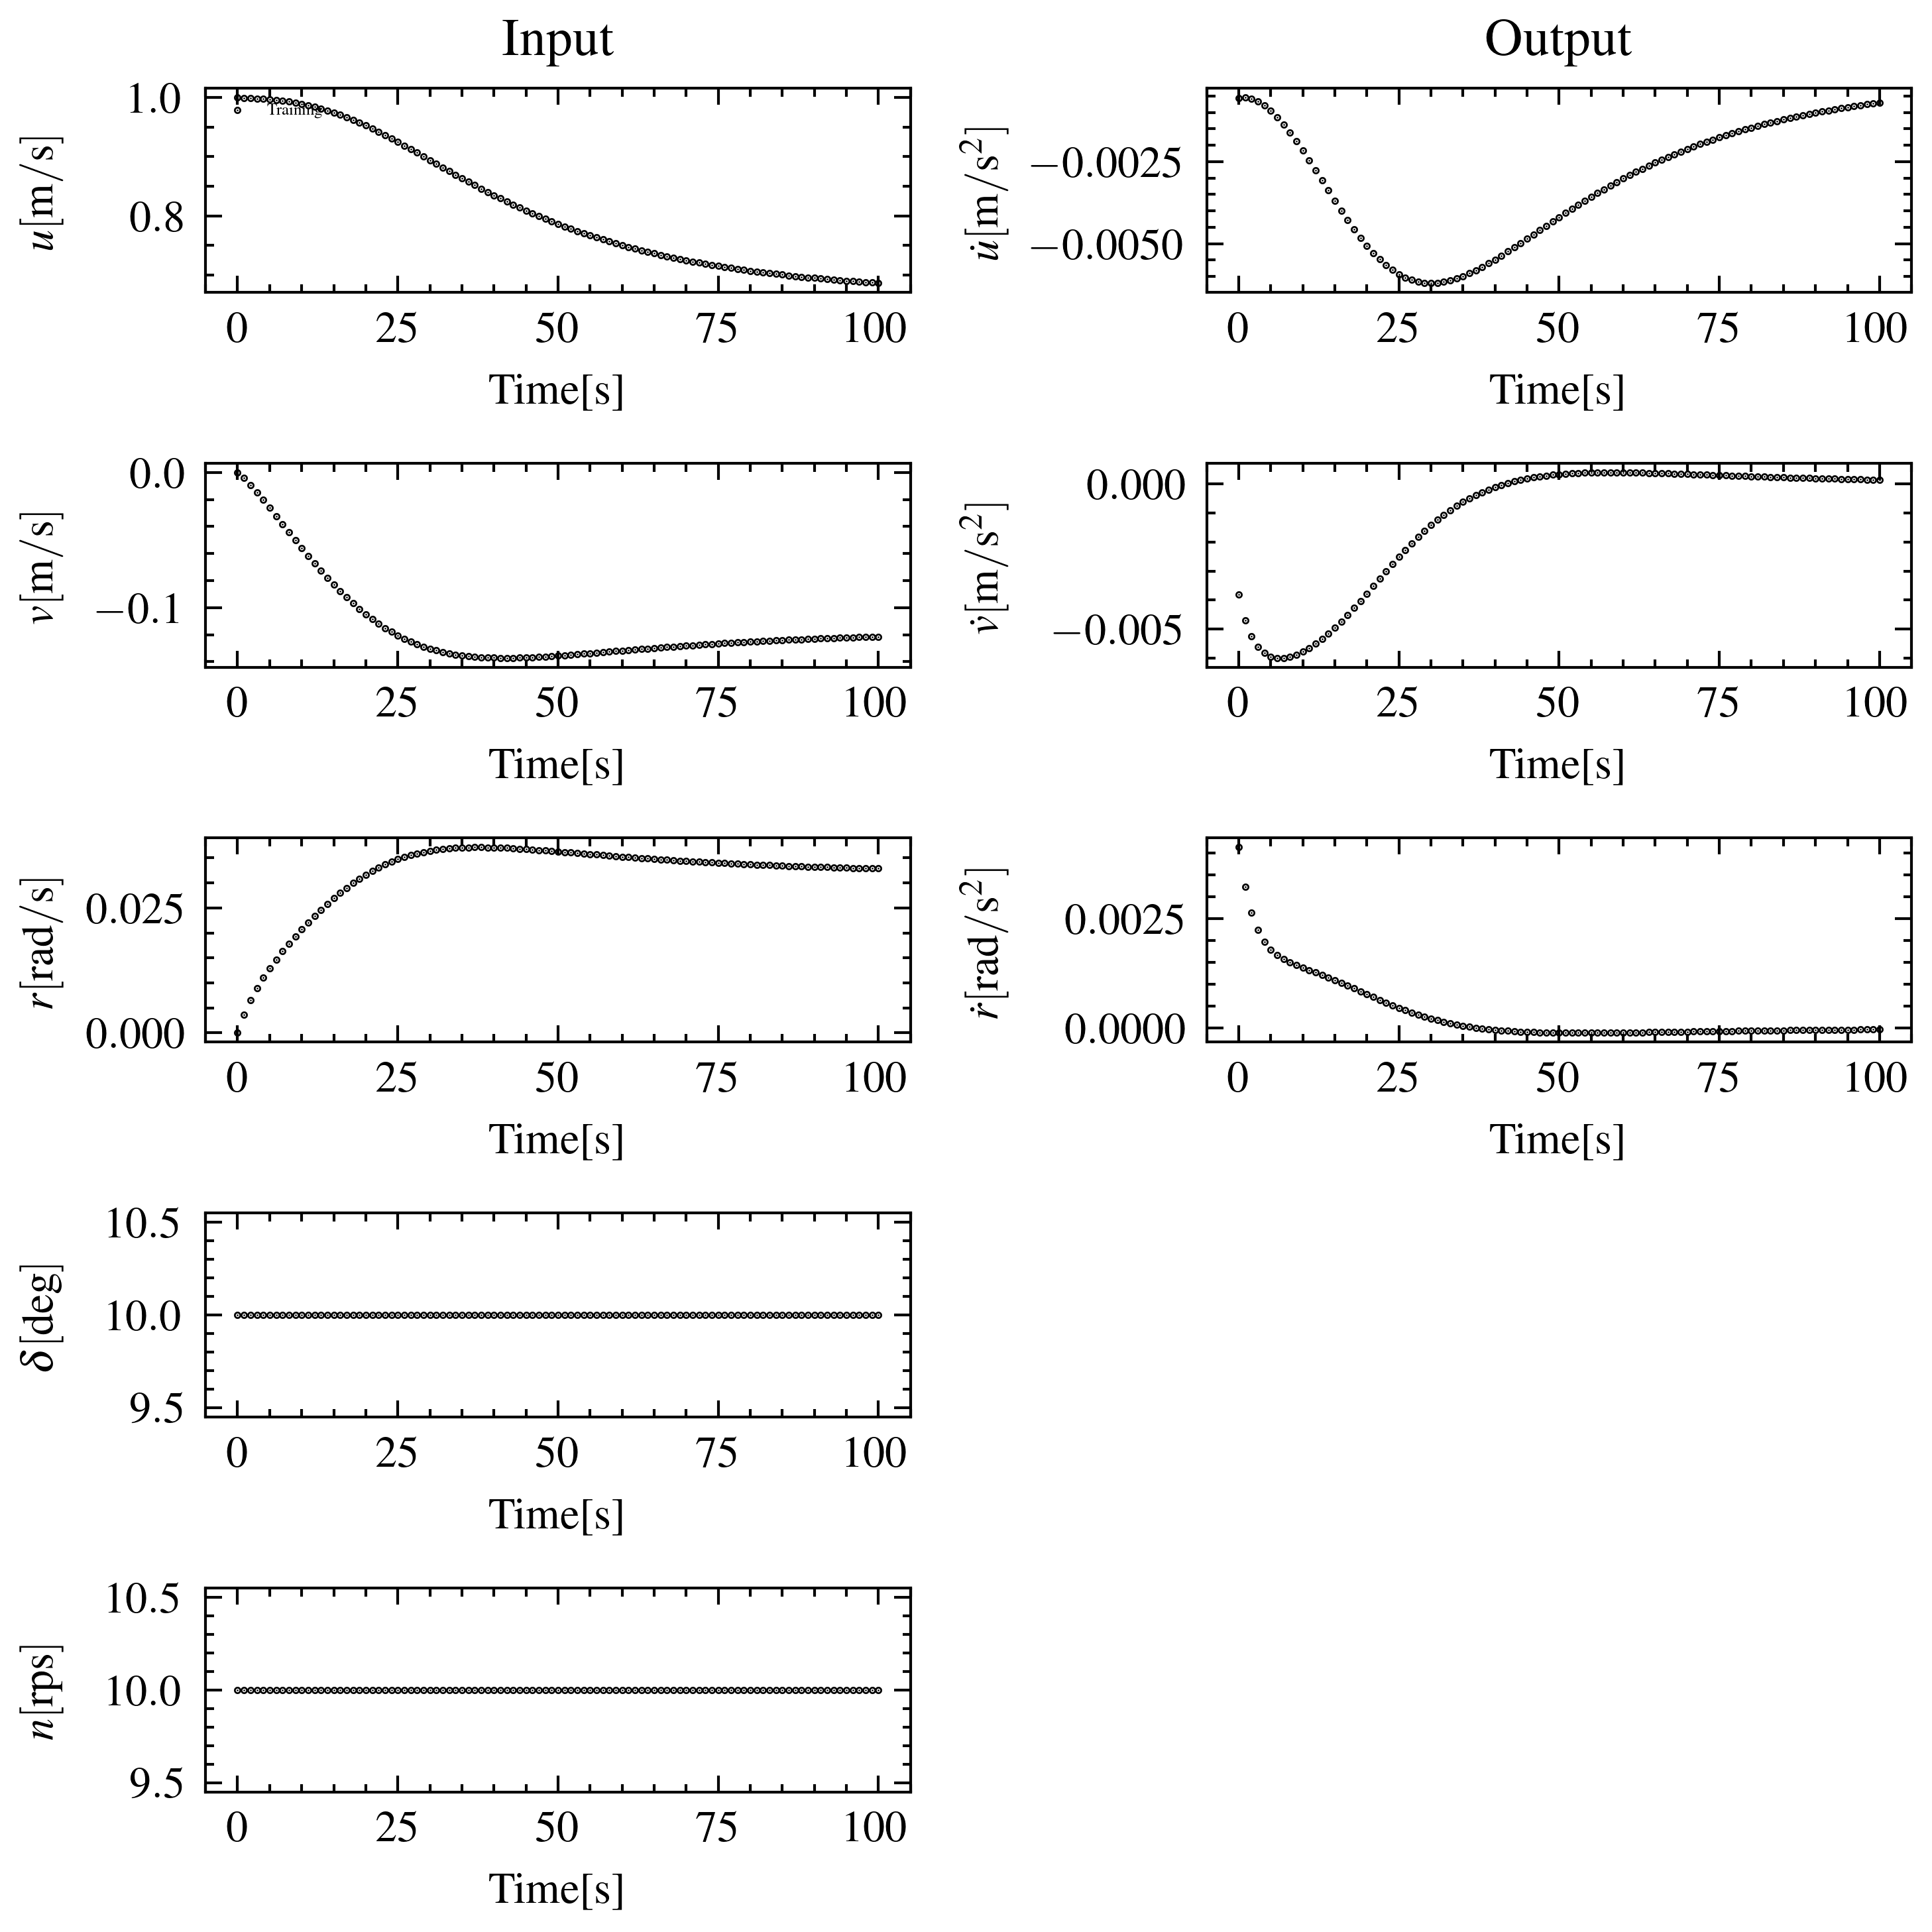

In [87]:
# 訓練データの図示
fig = plt.figure(figsize=(5,5))

ax1 = fig.add_subplot(5, 2, 1)  # 前後方向速度 u
ax1.scatter(data_train[1, :], data_train[5, :], color = "k", marker="o", s=0.1, label="Training")
ax1.set_xlabel("Time[s]")
ax1.set_ylabel(L"u\rm{[m/s]}")
ax1.set_title("Input")
ax1.legend(frameon=false, fontsize=3, loc="upper left")

ax2 = fig.add_subplot(5, 2, 3)  # 横方向速度 v
ax2.scatter(data_train[1, :], data_train[6, :], color = "k", marker="o", s=0.1)
ax2.set_xlabel("Time[s]")
ax2.set_ylabel(L"v\rm{[m/s]}")

ax3 = fig.add_subplot(5, 2, 5)  # 回頭角速度 r
ax3.scatter(data_train[1, :], data_train[7, :], color = "k", marker="o", s=0.1)
ax3.set_xlabel("Time[s]")
ax3.set_ylabel(L"r\rm{[rad/s]}")

ax4 = fig.add_subplot(5, 2, 7)  # 舵角 δ
ax4.scatter(data_train[1, :], data_train[8, :] .* (180/π), color = "k", marker="o", s=0.1)
ax4.set_xlabel("Time[s]")
ax4.set_ylabel(L"\delta\rm{[deg]}")

ax5 = fig.add_subplot(5, 2, 9)  # プロペラ回転数 n
ax5.scatter(data_train[1, :], data_train[9, :], color = "k", marker="o", s=0.1)
ax5.set_xlabel("Time[s]")
ax5.set_ylabel(L"n\rm{[rps]}")

ax6 = fig.add_subplot(5, 2, 2)  # 前後方向加速度 u'
ax6.scatter(data_train[1, :], data_train[2, :], color = "k", marker="o", s=0.1)
ax6.set_xlabel("Time[s]")
ax6.set_ylabel(L"\dot{u}\rm{[m/s^2]}")
ax6.set_title("Output")

ax7 = fig.add_subplot(5, 2, 4)  # 横方向加速度 v'
ax7.scatter(data_train[1, :], data_train[3, :], color = "k", marker="o", s=0.1)
ax7.set_xlabel("Time[s]")
ax7.set_ylabel(L"\dot{v}\rm{[m/s^2]}")

ax8 = fig.add_subplot(5, 2, 6)  # 回頭角加速度 r'
ax8.scatter(data_train[1, :], data_train[4, :], color = "k", marker="o", s=0.1)
ax8.set_xlabel("Time[s]")
ax8.set_ylabel(L"\dot{r}\rm{[rad/s^2]}")

fig.align_labels()
fig.tight_layout()
display(fig)

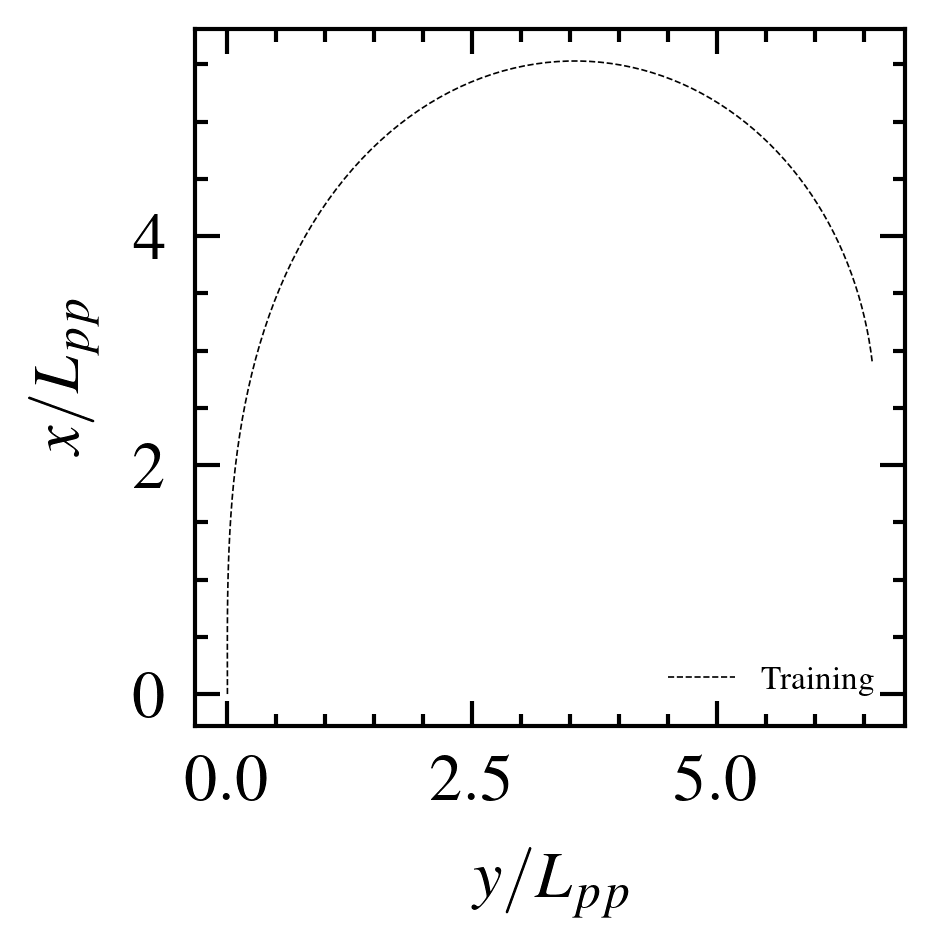

In [88]:
# 運動の軌跡
fig = plt.figure(figsize=(3,3))
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(data_train[11,:] ./ 7.0, data_train[10,:] ./ 7.0, c="k", lw=0.2, ls="--", label="Training")
ax1.set_xlabel(L"y/L_{pp}")
ax1.set_ylabel(L"x/L_{pp}")
ax1.legend(frameon=false, fontsize=4, loc="best")
fig.tight_layout()
display(fig)

In [89]:
# ニューラルネットワークモデル定義
input_size = 5    # 入力数
hidden_size = 128  # 隠れ層ユニット数
output_size = 3   # 出力数

# ランダムシード
rng = MersenneTwister(1234)

# NN
model = Chain(
               Dense(input_size => hidden_size, tanh; init = Flux.glorot_uniform(rng)),
               Dense(hidden_size => output_size, identity; init=Flux.glorot_uniform(rng)),
        )

# RNN
#model = Chain(
#              RNN(input_size => hidden_size, tanh; init_kernel=Flux.glorot_uniform(rng), init_recurrent_kernel=Flux.glorot_uniform(rng)), 
#              Dense(hidden_size => output_size, identity; init=Flux.glorot_uniform(rng)),
#            )

# LSTM
#model = Chain(
#               LSTM(input_size => hidden_size, tanh; init_kernel=Flux.glorot_uniform(rng), init_recurrent_kernel=Flux.glorot_uniform(rng)), 
#               Dense(hidden_size => output_size, identity; init=Flux.glorot_uniform(rng)),
#        )

# Denseレイヤーの活性化関数のデフォルトはidentity(恒等写像)、RNN・LSTMレイヤーの活性化関数のデフォルトはtanh

Chain(
  Dense(5 => 128, tanh),                # 768 parameters
  Dense(128 => 3),                      # 387 parameters
)                   # Total: 4 arrays, 1_155 parameters, 4.762 KiB.

In [90]:
# ニューラルネットワークの訓練
learning_rate = 0.0001       # 学習率
epoch = 10000                # エポック数
minibatch_size = batch_size  # ミニバッチサイズ(≦ batchsize)

# オプティマイザー(Adam)の初期化
opt_state = Flux.setup(Adam(learning_rate), model)

loss_train, _, _ = nn_train(loss_fnn,           # 損失関数(loss_fnn or loss_rnn)
                                     model,              # NNモデル
                                     opt_state,          # 最適化手法
                                     learning_rate,      # 学習率
                                     epoch,              # エポック数
                                     input_train_norm,   # 正規化された訓練データ(入力)
                                     output_train_norm,  # 正規化された訓練データ(出力)
                                     input_valid_norm,   # 正規化された検証データ(入力)
                                     output_valid_norm,  # 正規化された検証データ(出力)
                                     output_max,         # 正規化された値を元に戻す係数(出力)
                                     minibatch_size,     # ミニバッチサイズ
                            )
;
#println("Loss value after training is ", sqrt(loss_train[end]),"[m/s^2]")

In [91]:
# 訓練後のモデルを用いた運動推定(FNN)
data_pred, rmse_u, rmse_v, rmse_r, rmse = fnn_test(model,       # FNNモデル
                                                   t_max,       # シミュレーション継続[s]
                                                   data_train,  # 比べるデータセット
                                                   input_max,   # 正規化された値を元に戻す係数(入力)
                                                   output_max,  # 正規化された値を元に戻す係数(出力)
                                                 )

# 訓練後のモデルを用いた運動推定(RNN)
#data_pred, rmse_du, rmse_dv, rmse_dr, rmse_u, rmse_v, rmse_r, rmse = rnn_test(model,        # RNNモデル
#                                                                              memory_step,  # メモリステップ
#                                                                              t_max,        # シミュレーション継続時間[s]
#                                                                              t_smp,        # 比べるデータセットのサンプリング周期[s]
#                                                                              data_train,   # 比べるデータセット
#                                                                              input_max,    # 正規化された値を元に戻す係数(入力)
#                                                                              output_max,   # 正規化された値を元に戻す係数(出力)
#                                                                            )

println("RMSE between true and estimated surge velocity : ", rmse_u, "m/s")
println("RMSE between true and estimated sway velocity : ", rmse_v, "m/s")
println("RMSE between true and estimated yaw rate : ", rmse_r, "rad/s")
println("RMSE between true and estimated trajectory : ", rmse, "m")

RMSE between true and estimated surge velocity : 0.00021095859m/s
RMSE between true and estimated sway velocity : 0.00022990757m/s
RMSE between true and estimated yaw rate : 8.344558e-5rad/s
RMSE between true and estimated trajectory : 0.0020421327m


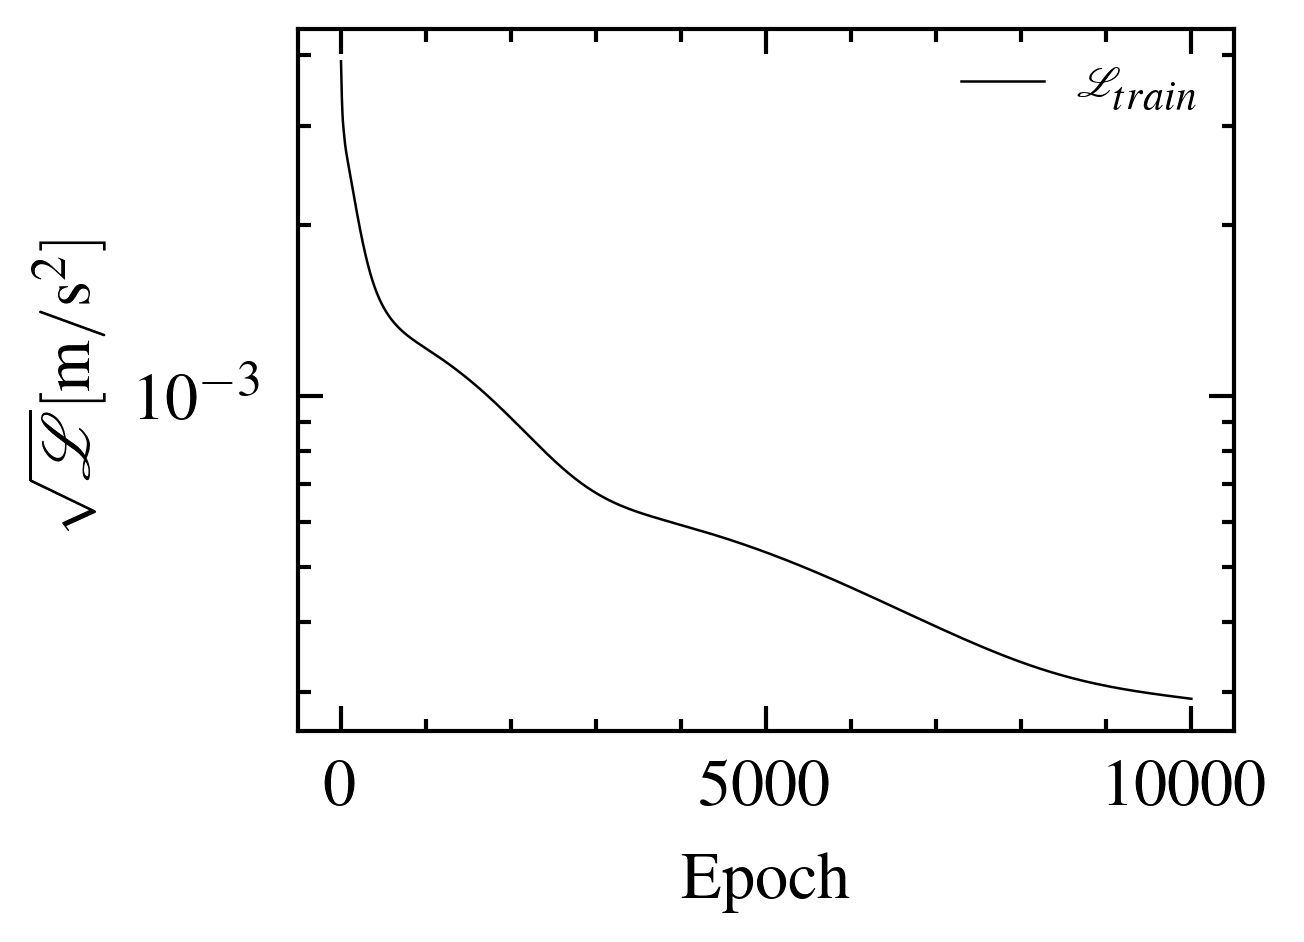

In [92]:
# 損失関数の遷移
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(2, 2, 1)
ax.plot(sqrt.(loss_train[:]), color = "k", lw=0.3, ls="-", label=L"\mathcal{L}_{train}")
#ax.plot(sqrt.(loss_valid[:]), color = "k", lw=0.3, ls="--", label=L"\mathcal{L}_{valid}")
ax.set_yscale("log")
ax.set_xlabel("Epoch")
ax.set_ylabel(L"\sqrt{\mathcal{L}}\rm{[m/s^2]}")
#ax.set_yticks([10^(-5),10^(-4),10^(-3),10^(-2)])
ax.legend(frameon=false, fontsize=5, loc="best")
fig.tight_layout()
display(fig)

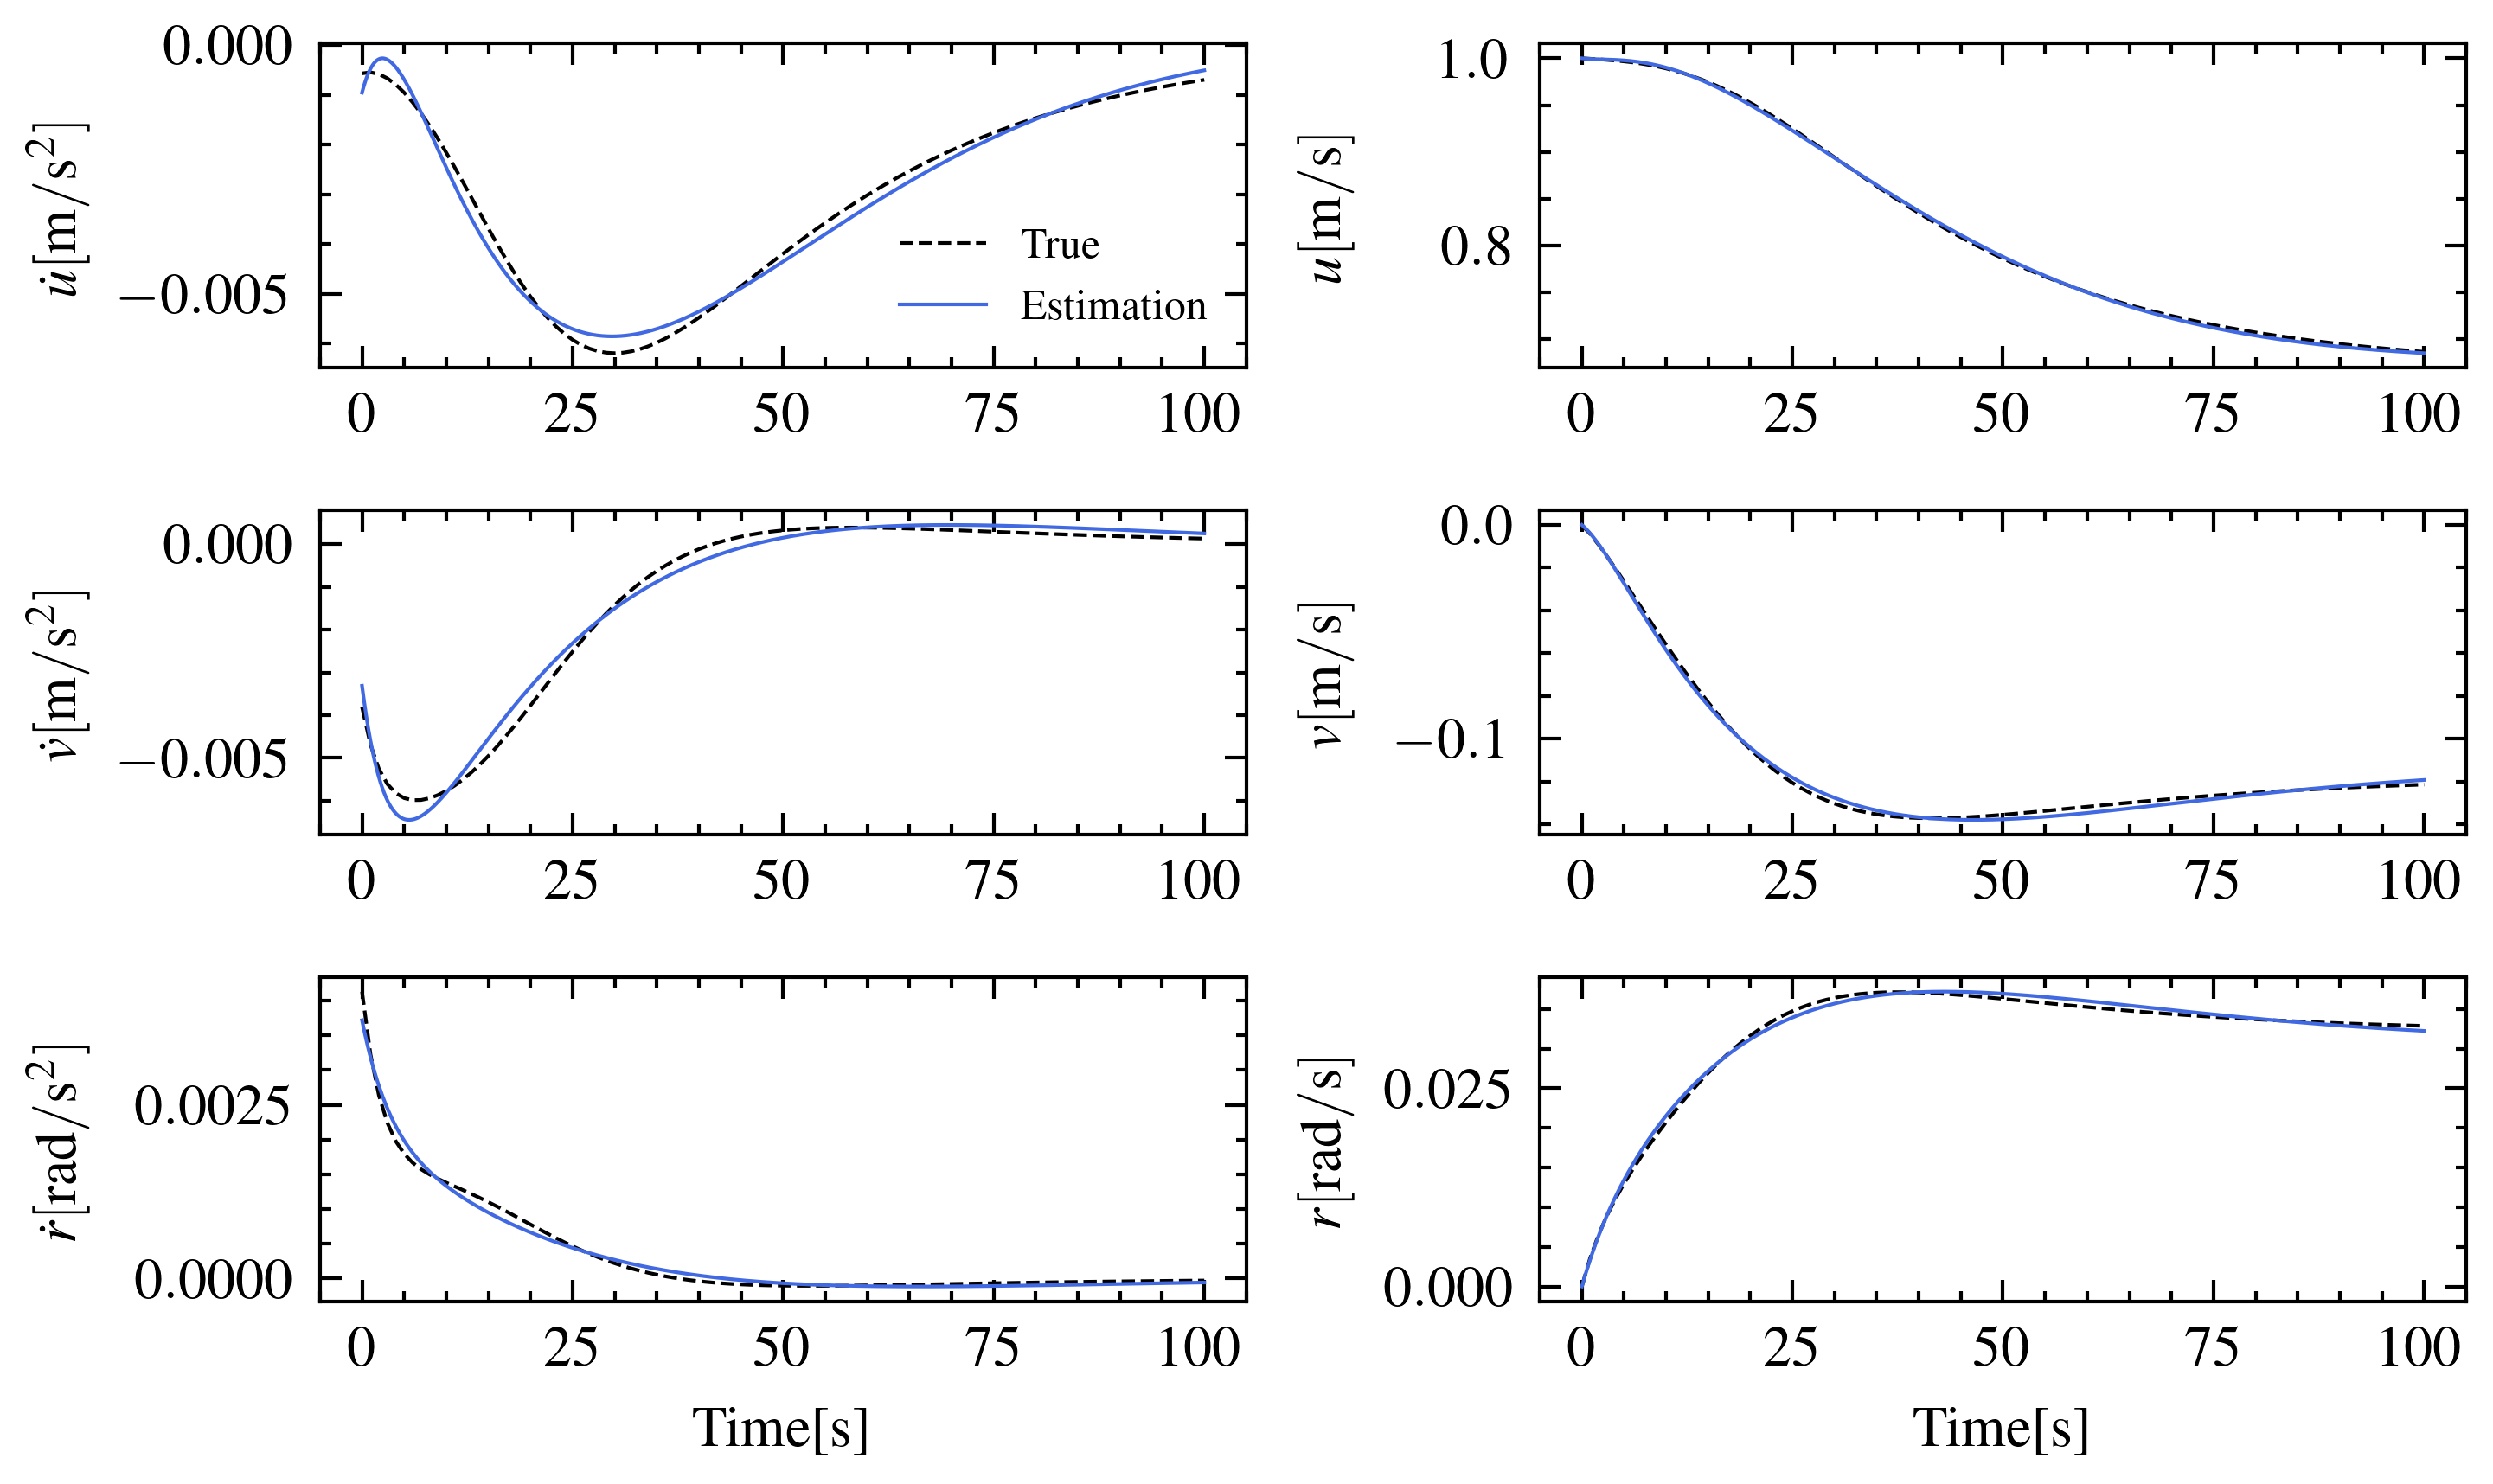

In [93]:
# 訓練データ推定結果(加速度、速度)
fig = plt.figure(figsize=(5,3))

ax1 = fig.add_subplot(3, 2, 1)
ax1.plot(data_train[1, :], data_train[2, :], color = "k", lw=0.5, ls="--", label="True")
ax1.plot(data_pred[1, :], data_pred[2, :], color = "royalblue", lw=0.5, ls="-", label="Estimation")
ax1.set_ylabel(L"\dot{u}\rm{[m/s^2]}")
ax1.legend(frameon=false, fontsize=6, loc="best")

ax2 = fig.add_subplot(3, 2, 3)
ax2.plot(data_train[1, :], data_train[3, :], color = "k", lw=0.5, ls="--")
ax2.plot(data_pred[1, :], data_pred[3, :], color = "royalblue", lw=0.5, ls="-")
ax2.set_ylabel(L"\dot{v}\rm{[m/s^2]}")

ax3 = fig.add_subplot(3, 2, 5)
ax3.plot(data_train[1, :], data_train[4, :], color = "k", lw=0.5, ls="--")
ax3.plot(data_pred[1, :], data_pred[4, :], color = "royalblue", lw=0.5, ls="-")
ax3.set_xlabel("Time[s]")
ax3.set_ylabel(L"\dot{r}\rm{[rad/s^2]}")

ax4 = fig.add_subplot(3, 2, 2)
ax4.plot(data_train[1, :], data_train[5, :], color = "k", lw=0.5, ls="--")
ax4.plot(data_pred[1, :], data_pred[5, :], color = "royalblue", lw=0.5, ls="-")
ax4.set_ylabel(L"u\rm{[m/s]}")

ax5 = fig.add_subplot(3, 2, 4)
ax5.plot(data_train[1, :], data_train[6, :], color = "k", lw=0.5, ls="--")
ax5.plot(data_pred[1, :], data_pred[6, :], color = "royalblue", lw=0.5, ls="-")
ax5.set_ylabel(L"v\rm{[m/s]}")

ax6 = fig.add_subplot(3, 2, 6)
ax6.plot(data_train[1, :], data_train[7, :], color = "k", lw=0.5, ls="--")
ax6.plot(data_pred[1, :], data_pred[7, :], color = "royalblue", lw=0.5, ls="-")
ax6.set_xlabel("Time[s]")
ax6.set_ylabel(L"r\rm{[rad/s]}")

fig.align_labels()
fig.tight_layout()
display(fig)

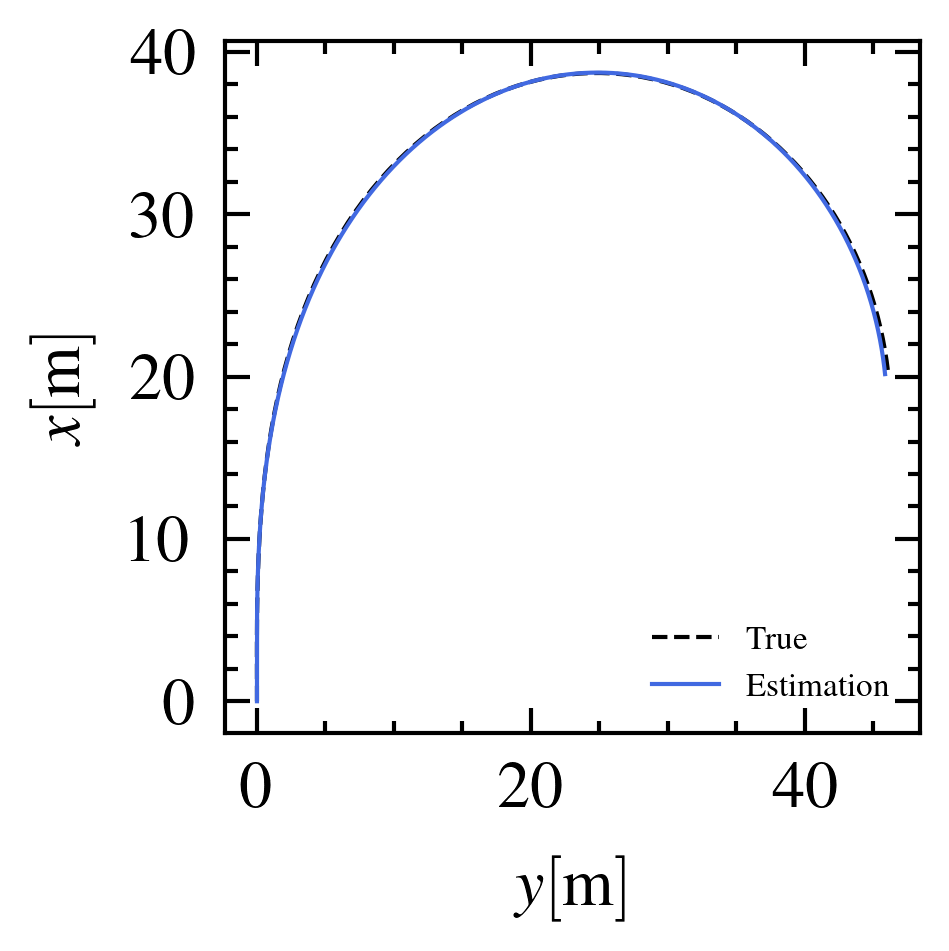

In [94]:
# 訓練データ推定結果(軌跡)
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(2, 2, 1)
ax.plot(data_train[11, :], data_train[10, :], color = "k", lw=0.5, ls="--", label="True")
ax.plot(data_pred[11, :], data_pred[10, :], color = "royalblue", lw=0.5, ls="-", label="Estimation")
ax.set_xlabel(L"y\rm{[m]}")
ax.set_ylabel(L"x\rm{[m]}")
ax.legend(frameon=false, fontsize=4, loc="best")
#ax.set_aspect(1)
fig.align_labels()
fig.tight_layout()
display(fig)